In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import StableDiffusionPipeline   

device = "cuda"

In [2]:
# img_path = f"./dog.png"
# mask_path = f"./dog_mask.png"
# 
# img = Image.open(img_path)
# mask = Image.open(mask_path)

In [3]:
# Load the pipeline
model_id = "/data2/yuanshou/tmp/sdwebui/to3D/310/stable-dreamfusion-main/model/v2-1/v2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)#, revision="fp16"

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

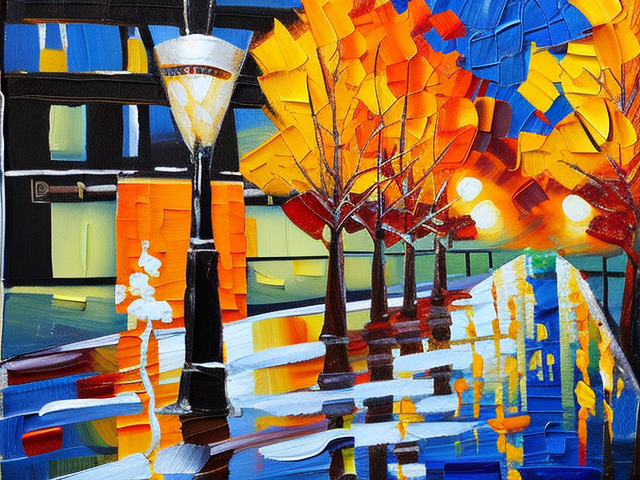

In [4]:
generator = torch.Generator(device=device).manual_seed(42)

pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", 
    negative_prompt="Oversaturated, blurry, low quality",
    height=480, width=640,     # 采样噪声大小（生成图片的大小）
    guidance_scale=8,          # 对prompt的置信程度
    num_inference_steps=35,    # 设置去噪步长
    generator=generator        # 固定随机种子
)

pipe_output.images[0]

In [5]:
generator = torch.Generator(device=device).manual_seed(42)

pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", 
    negative_prompt="Oversaturated, blurry, low quality",
    height=481, width=640,     # 采样噪声大小（生成图片的大小）
    guidance_scale=8,          # 对prompt的置信程度
    num_inference_steps=35,    # 设置去噪步长
    generator=generator        # 固定随机种子
)

pipe_output.images[0]


 # negative prompt and guidance scale are related to classifer-free guidance(CFG)

ValueError: `height` and `width` have to be divisible by 8 but are 481 and 640.

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

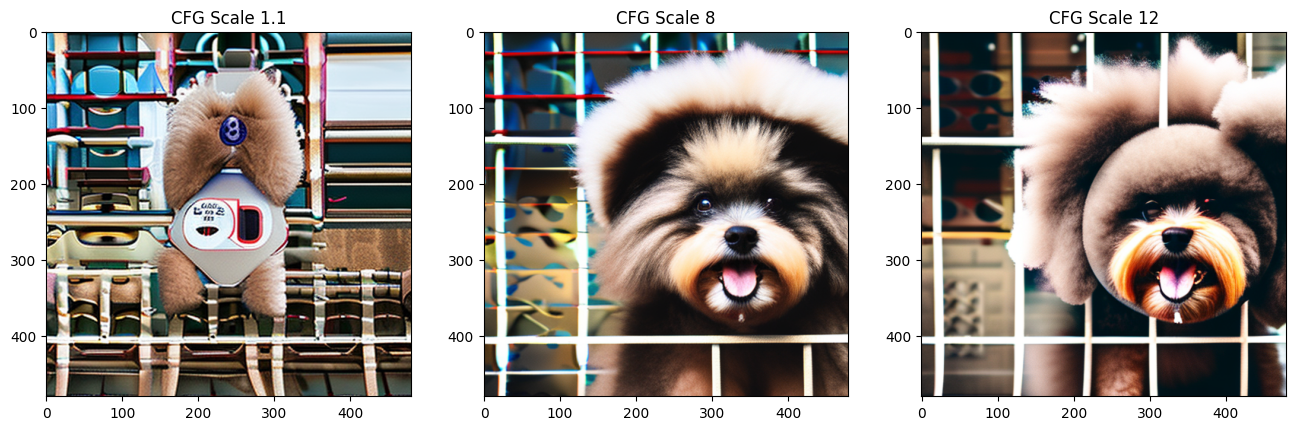

In [6]:
# 查看不同的忠诚度 guidance_scale 对结果的影响
cfg_scales = [1.1, 8, 12]
prompt = "A fluffy dog with a rock star suits"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

# Pipeline Component

In [7]:
print(list(pipe.components))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


## VAE 用于将图片转换到隐空间

(512, 512, 3)


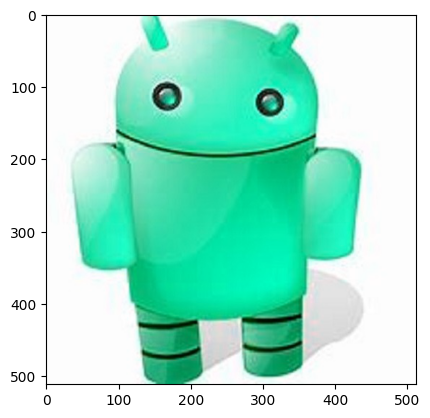

In [8]:
import torchvision.transforms as transforms
import cv2 as cv


img = cv.imread('/data2/yuanshou/tmp/data/pics/android.jpg')
print(img.shape) # numpy数组格式为（H,W,C）
plt.imshow(img)

In [9]:
# 把图片转成ＢＣＨＷ格式
transf = transforms.ToTensor()
img_tensor = transf(img).view(1,3,512,512).to(device) # tensor数据格式是torch(C,H,W)
img_tensor = torch.tensor(img_tensor,dtype=torch.float16)
print(img_tensor.shape)

torch.Size([1, 3, 512, 512])


/tmp/ipykernel_452655/3447913708.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img_tensor,dtype=torch.float16)


In [10]:
# 把RGB图片转换到隐空间
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(img_tensor).latent_dist.mean # 0.18215 scaling factor
print("Encoded latents shape:", latents.shape)

Encoded latents shape: torch.Size([1, 4, 64, 64])


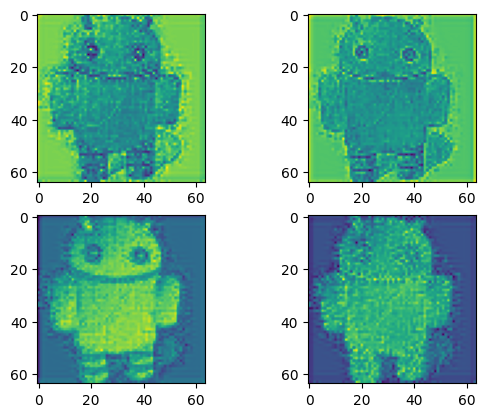

In [11]:
latent1 = latents[:,[0],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent2 = latents[:,[1],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent3 = latents[:,[2],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent4 = latents[:,[3],:,:][0].detach().cpu().numpy().transpose(1,2,0)
plt.subplot(2,2,1)
plt.imshow(latent1)
plt.subplot(2,2,2)
plt.imshow(latent2)
plt.subplot(2,2,3)
plt.imshow(latent3)
plt.subplot(2,2,4)
plt.imshow(latent4)

In [12]:
# 对隐空间中的图片进行解码，得到RGB图片
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample 
print("Decoded images shape:", decoded_images.shape)

Decoded images shape: torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


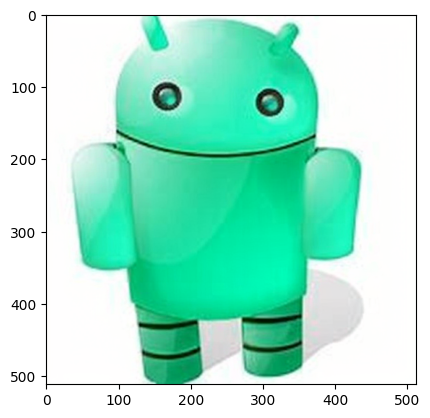

In [13]:
plt.imshow(decoded_images[0].detach().cpu().numpy().astype(float).transpose(1, 2, 0))

## The Tokenizer and Text Encoder (high level)


In [14]:
# tokenize：把句子当中的每个单词转换为index(token)
input_ids = pipe.tokenizer("A Chinese Porcelain with Dragon Pattern")["input_ids"]
print(input_ids)
print("Input ID -> decoded token")
for input_id in input_ids:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

[49406, 320, 4271, 20451, 593, 5471, 7447, 49407]
Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
4271 -> chinese
20451 -> porcelain
593 -> with
5471 -> dragon
7447 -> pattern
49407 -> <|endoftext|>


In [15]:
input_ids = pipe.tokenizer(["A Chinese Porcelain with Dragon Pattern"])["input_ids"]
print(input_ids)
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

[[49406, 320, 4271, 20451, 593, 5471, 7447, 49407]]
Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
4271 -> chinese
20451 -> porcelain
593 -> with
5471 -> dragon
7447 -> pattern
49407 -> <|endoftext|>


In [16]:
# 把句子的 token 交给 text_encoder
# 1.转成tensor
input_ids = torch.tensor(input_ids).to(device)

In [17]:
print(type(pipe.text_encoder(input_ids)),"\n",pipe.text_encoder(input_ids))
# 2.对一句话的idx进行特征提取
print(pipe.text_encoder(input_ids)["last_hidden_state"].shape)
print(pipe.text_encoder(input_ids)["pooler_output"].shape)

<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'> 
 BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3137, -0.4475, -0.0083,  ...,  0.2544, -0.0324, -0.2959],
         [ 0.1992, -1.6914, -0.8950,  ...,  0.4663, -0.0972, -2.1484],
         [-0.1631, -0.7319, -0.4309,  ...,  0.9180, -2.1309,  0.4575],
         ...,
         [-0.1340,  0.3230, -0.2219,  ...,  0.0957, -0.1101, -0.1542],
         [ 0.1593, -0.9102, -0.4785,  ..., -0.5298,  0.1266, -0.0201],
         [-0.8096, -0.7046,  0.1528,  ..., -0.2756,  1.1699,  0.7539]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8096, -0.7046,  0.1528,  ..., -0.2756,  1.1699,  0.7539]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>), hidden_states=None, attentions=None)
torch.Size([1, 8, 1024])
torch.Size([1, 1024])


In [36]:
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

# 参数 prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
text_embeddings = pipe._encode_prompt("A painting of a dog", device, 1, True, '')
print(text_embeddings.shape)

Text embeddings shape: torch.Size([1, 8, 1024])
torch.Size([2, 77, 1024])


In [37]:
text_embeddings[0]

tensor([[-3.1348e-01, -4.4751e-01, -8.4305e-03,  ...,  2.5439e-01,
         -3.2654e-02, -2.9590e-01],
        [ 1.4092e+00,  7.3662e-03, -4.2944e-01,  ...,  1.0371e+00,
         -6.7236e-01,  1.5039e+00],
        [ 1.8633e+00, -1.0898e+00, -1.0596e+00,  ...,  2.0293e+00,
         -1.1387e+00, -1.8872e-01],
        ...,
        [ 9.9716e-03, -1.4951e+00, -3.8867e-01,  ..., -1.8176e-01,
         -3.2153e-01, -1.7075e-02],
        [ 3.0365e-02, -1.5518e+00, -4.0845e-01,  ..., -4.4629e-01,
         -3.9771e-01,  1.9336e-01],
        [-6.9458e-02, -2.6172e+00, -1.0518e+00,  ..., -7.6342e-04,
         -5.0488e-01,  4.0308e-01]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)

In [39]:
text_embeddings[1].shape

torch.Size([77, 1024])

## UNet

In [79]:
# 定义时间步长
timestep = pipe.scheduler.timesteps[0]
# 利用上方 VAE encoder 产生的 latent
latentrd = torch.randn(1, 4, 64, 64,dtype=torch.float16).to(device)
# latents = torch.tensor(latents,dtype=torch.float16)
# 定义引导文本
text_embeddings =  pipe.text_encoder(input_ids)['last_hidden_state']
text_embeddings = pipe._encode_prompt("A bird", device, 1, True, '')[1].view(1,77,1024)

In [80]:
timestep

tensor(953, device='cuda:0')

In [81]:
# model prediction
with torch.no_grad():
    unet_output = pipe.unet(latentrd, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


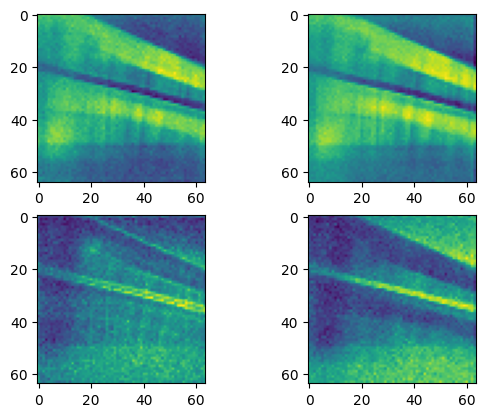

In [82]:
latent1 = unet_output[:,[0],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent2 = unet_output[:,[1],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent3 = unet_output[:,[2],:,:][0].detach().cpu().numpy().transpose(1,2,0)
latent4 = unet_output[:,[3],:,:][0].detach().cpu().numpy().transpose(1,2,0)
plt.subplot(2,2,1)
plt.imshow(latent1)
plt.subplot(2,2,2)
plt.imshow(latent2)
plt.subplot(2,2,3)
plt.imshow(latent3)
plt.subplot(2,2,4)
plt.imshow(latent4)

In [83]:
# 对隐空间中的图片进行解码，得到RGB图片
with torch.no_grad():
  decoded_images = pipe.vae.decode(unet_output / 0.18215).sample 
print("Decoded images shape:", decoded_images.shape)

Decoded images shape: torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


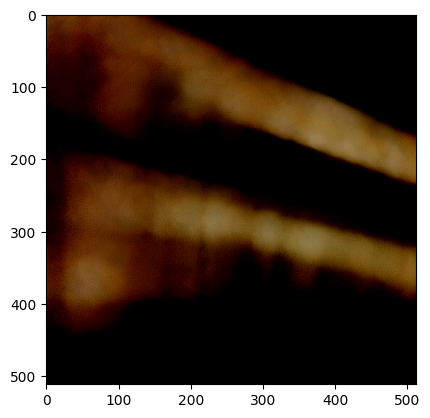

In [84]:
plt.imshow(decoded_images[0].detach().cpu().numpy().astype(float).transpose(1, 2, 0))

## Scheduler

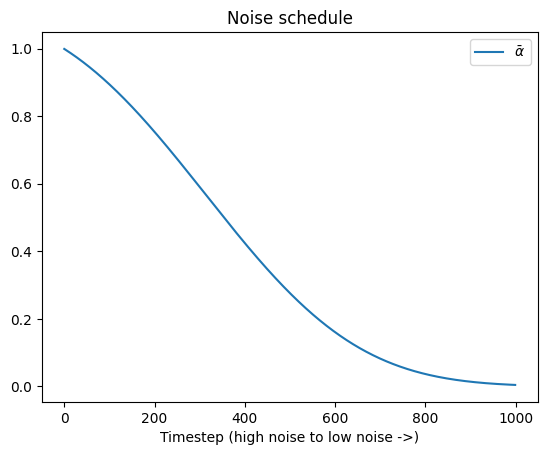

In [85]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}


  0%|          | 0/50 [00:00<?, ?it/s]

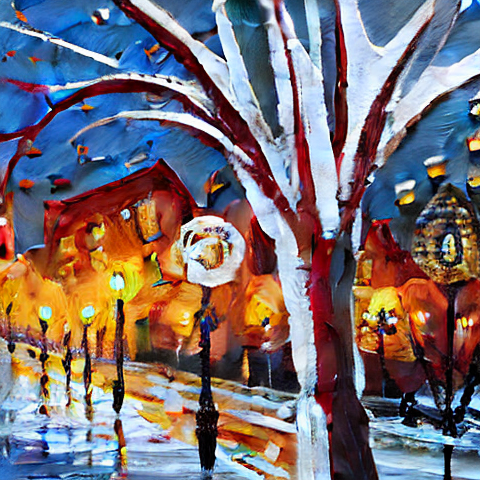

In [86]:
# 导入其他噪声分配器
from diffusers import LMSDiscreteScheduler

# 换用其他噪声分配器
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# 查看噪声分配器
print('Scheduler config:', pipe.scheduler)

# 用新的噪声分配器生成图像
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

# DIY txt2img

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image

In [88]:
def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [0]:
pipe.scheduler.init_noise_sigma

In [107]:
pipe.tokenizer.model_max_length,

(77,)

In [96]:
@torch.no_grad()
def generate_simplified(
    # 定义中文提示词
    prompt = ["a horrible ghost"],
    # 定义用于无分类的uncond_prompt
    uncond_prompt = [""],
    # 定义推理步长
    num_inference_steps = 50,
    # 定义对prompt的忠诚度
    guidance_scale = 7.5,
    # 定义图像的 B H W
    batch_size = 1,
    height = 512,
    width = 512,
    # 暂时不配置generator（固定随机种子用到）
    generator = None
    ):
        
    # 对文本进行编码
    text_inputs = pipe.tokenizer(
        # 提示词
        prompt,
        # 采用最大长度法截断
        padding="max_length",
        # 定义最大长度 diffuser默认最大长度为77
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt", 
    )

    # 得到输入提示词的idx
    text_input_ids = text_inputs.input_ids
    # 对idx/token进行编码，得到提示词的embedding
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]
    # 记录句子的batchSize 和每句话的句子长度（77）
    bs_embed, seq_len, _ = text_embeddings.shape


    # 负面提示词的embedding
    # 确保最大截断长度和正向提示词相等
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_prompt,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt"
    )

    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # duplicate unconditional embeddings for each generation per prompt
    # 每个提示每代重复无条件嵌入
    seq_len = uncond_embeddings.shape[1]
    uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1) 
    uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)

    # concat
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # 定义latent的图片大小
    latants_shape = (batch_size, pipe.unet.in_channels, height//8, width//8)
    latents_dtype = text_embeddings.dtype
    latents = torch.randn(latants_shape, generator=generator, device=pipe.device, dtype=latents_dtype)

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)
    timsteps_tensor = pipe.scheduler.timesteps.to(pipe.device)

    latents = latents * pipe.scheduler.init_noise_sigma

    # main diffusion process
    for i, t in enumerate(pipe.progress_bar(timsteps_tensor)):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # 利用Unet网络，根据潜空间的图片输入，当前扩散步长，以及正负提示词编码，预测得到上一个步骤加了多少噪声
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # 1.无条件的预测噪声   
        # 2.有条件的预测噪声   
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                   # uncond - guidance_scale * uncond + guidance_scale * cond
                   # (1 - guidance_scale) * uncond    + guidance_scale * 

        # 更新latents，得到去掉本次噪声后的latents
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # 对latent进行处理，得到RGB图片
    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)

    image = image.cpu().permute(0, 2, 3, 1).float().numpy()

    return image


In [105]:
if __name__ == "__main__":
    pipe = StableDiffusionPipeline.from_pretrained(
        "/data2/yuanshou/tmp/sdwebui/to3D/310/stable-dreamfusion-main/model/v2-1/v2-1",
        revision="fp16", # model version
        torch_dtype=torch.float16
    ).to("cuda")
        
    image = generate_simplified(
        prompt =["a cute ghost"]
    )

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_452655/3667469417.py:47: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latants_shape = (batch_size, pipe.unet.in_channels, height//8, width//8)


  0%|          | 0/50 [00:00<?, ?it/s]

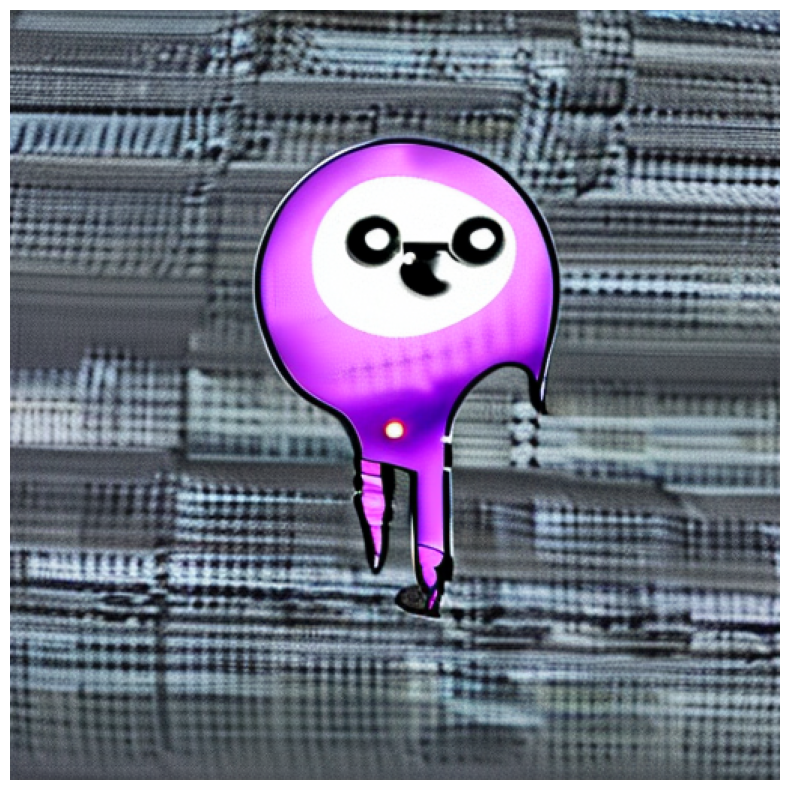

In [106]:
plt_show_image(image[0])

# img2img API

In [ ]:
# /mnt/mydrive/datas/model/Ghibli-Diffusion
import torch
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
import matplotlib.pyplot as plt

device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("/mnt/mydrive/datas/model/Ghibli-Diffusion", torch_dtype=torch.float16).to(
    device
)

init_image = Image.open("./landscape.jpg").convert("RGB")
init_image.thumbnail((768, 768))
init_image

In [ ]:
prompt = "ghibli style, a fantasy landscape with castles"
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator, num_inference_steps=50).images[0]
image

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = lms
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator).images[0]
image

In [ ]:
init_image = Image.open("./dog.png")# .convert("RGB")

result_image = pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

# Inpaiting API

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

# In-Painting
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("/mnt/mydrive/datas/model/stable-diffusion-inpainting")
pipe = pipe.to(device)

In [ ]:
img_path = f"./dog.png"
mask_path = f"./dog_mask.png"

img = Image.open(img_path)
mask = Image.open(mask_path)

prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=img, mask_image=mask).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(img);axs[0].set_title('Input Image')
axs[1].imshow(mask);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

# DIY img2img

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
import torchvision.transforms as transforms
import PIL
from PIL import Image
import matplotlib.pyplot as plt


def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def seed_everything(seed=42):
    import torch
    import numpy as np
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def save_image(image, filename):
    img = Image.fromarray((image * 255).astype('uint8'))
    img.save(filename)

@torch.no_grad()
def preprocess(image):
    preprocess_pipeline = transforms.Compose([
        transforms.Resize(512), # Resize to the same size as your model input
        transforms.ToTensor(), # Convert PIL image to Torch tensor
    ])
    image_tensor = preprocess_pipeline(image)
    image_tensor.unsqueeze_(0)  # Add batch dimension
    return image_tensor


In [ ]:
@torch.no_grad()
def generate_img2img_simplified(
    prompt,
    init_image,
    uncond_prompt = [""],
    strength = 0.8, # strength of the image conditioning
    batch_size = 1,
    num_inference_steps = 50,
    do_classifier_free_guidance = True,
    guidance_scale = 7.5
):

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]

    # get unconditional embeddings for classifier free guidance
    uncond_tokens = uncond_prompt
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # classifier free guidance
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    #####################################################################
    # encode the init image into latents and scale the latents
    latents_dtype = text_embeddings.dtype
    if isinstance(init_image, PIL.Image.Image):
        init_image = preprocess(init_image)
    init_image = init_image.to(device=pipe.device, dtype=latents_dtype)
    init_latent_dist = pipe.vae.encode(init_image).latent_dist
    init_latents = init_latent_dist.sample()
    init_latents = 0.18215 * init_latents
    #####################################################################

    # get the original timestep using init_timestep
    offset = pipe.scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = pipe.scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * batch_size, device=pipe.device)

    # add noise to latents using the timesteps
    noise = torch.randn(init_latents.shape, device=pipe.device, dtype=latents_dtype)
    init_latents = pipe.scheduler.add_noise(init_latents, noise, timesteps)

    latents = init_latents

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps = pipe.scheduler.timesteps[t_start:].to(pipe.device)

    for i, t in enumerate(pipe.progress_bar(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image
    

In [ ]:
# seed_everything(1024)
device = "cuda"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained( 
    "/mnt/mydrive/datas/model/Ghibli-Diffusion",
    revision="fp16",  torch_dtype=torch.float16,
).to(device)

# Load the initial image if required.
init_image = Image.open("./landscape.png")


In [ ]:
# Now we can use the function to generate an image.
with torch.no_grad():
    image = generate_img2img_simplified(
        prompt = ["ghibli style, a fantasy landscape with castles"],
        uncond_prompt = [""],
        init_image = init_image,
        strength = 0.75,
        batch_size = 1,
    )
plt_show_image(image[0])